# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

## The Baseline

First, we load up the common elements to be used in the traditional and federated approaches. 


### The Model
We start with the model.

In [1]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

# # Optional model for fun

# import torch.nn.functional as F

# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=0) # value 0 was chosen arbitrarily to quiet a warning. Penny'll start a fire.

#     def name(self):
#         return 'LeNet'

### The Data - Standard MNIST Datasets
Here we get plain vanilla MNIST datasets, balanced the way the gods intended, and we make datatloaders from them. Nothing exciting to see here. This is our baseline. If you don't already have the MNIST data on your machine, the calls to `torchvision.datasets.MNIST(... dowload=True ...)` will download it for you.

In [2]:
# load the data

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data

data_path = './MNIST-data/raw'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [3]:
# create dataloaders

from torch.utils.data import DataLoader

batch_size = 128

# create standard dataloaders using all of the MNIST data - this is for baseline purposes
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

Let's check out the goods. We expect than the out-of-the-box MNIST dataset will have roughly equal numbers of samples for each numeral.

In [4]:
from collections import Counter

test_counts = Counter(int(y) for y in test_dset.targets).most_common()
print("Test counts: \n", test_counts)
print("Test max/min: %.2f" % (test_counts[0][1] / test_counts[9][1]), "\n")

train_counts = Counter(int(y) for y in train_dset.targets).most_common()
print("Train counts: ", train_counts)
print("Train max/min: %.2f" % (train_counts[0][1] / train_counts[9][1]))

Test counts: 
 [(1, 1135), (2, 1032), (7, 1028), (3, 1010), (9, 1009), (4, 982), (0, 980), (8, 974), (6, 958), (5, 892)]
Test max/min: 1.27 

Train counts:  [(1, 6742), (7, 6265), (3, 6131), (2, 5958), (9, 5949), (0, 5923), (6, 5918), (8, 5851), (4, 5842), (5, 5421)]
Train max/min: 1.24


The training data looks reasonably well distributed, and the plots below confirm it.

TODO: Use a better metric of distribution? std?

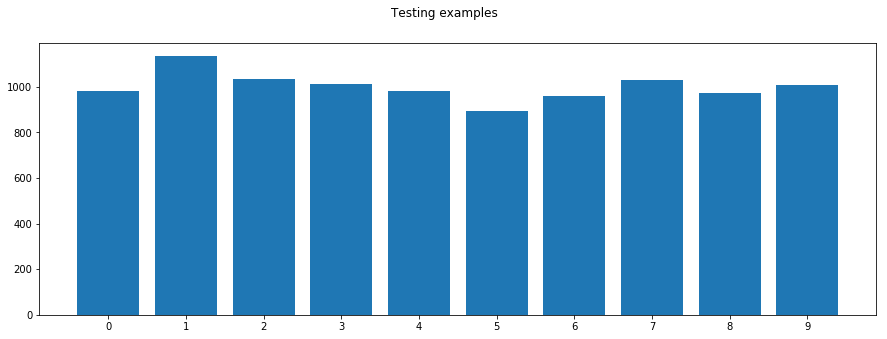

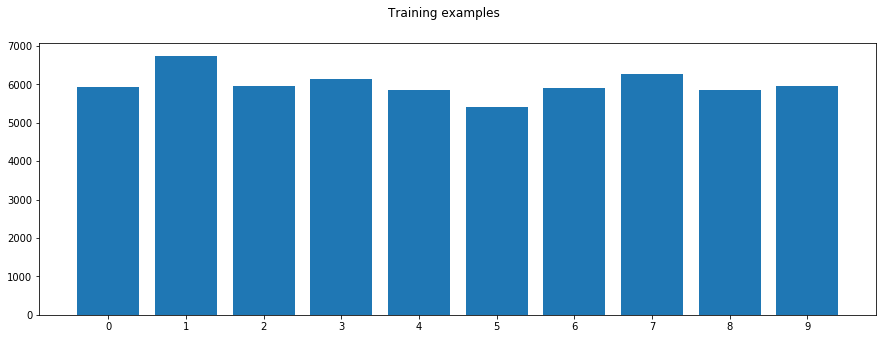

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Testing examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist(test_dloader.dataset.targets, bins=range(11), histtype='bar', align='left', rwidth=0.8)

fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Training examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist(train_dloader.dataset.targets, bins=range(11), histtype='bar', align='left', rwidth=0.8);

NOTE: DO WE WANT TO JUST TRAIN THE BASELINE MODEL HERE BEFORE STACKING THE DECK?

### Stacking a Deck (Skewing the Data)

We know the baseline data is pretty even across numerals. Now we need a way to "stack the deck" of examples that each worker sees. This method creates a dataset that is randomly sampled from a given dataset with the random sampling biased according to a dictionary of weights for each label.

In [6]:
from torch.utils.data import WeightedRandomSampler

def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])

#     for label in test_dset.targets:
#         weights.append(label_weights[int(label)])
# TODO / MLW : how to speed this up - currently takes about a minute to train ten stacked training sets
    
    return WeightedRandomSampler(weights, N, replacement=False)

And this is where we get the dictionary of weights. For simplicity's sake, we just take a list of labels to be sampled "normally" and the rest are biased against. So, preserving 3s and skewing everything else by a factor of 0.9 shoud get a set of weights that results in a dataset that is slightly heavy on 3s compared to everything else. In an an extreme example, preserving only 3s, with a skew of 0, will produce weights that will yield a dataset of only 3s.

In [7]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

### 

Here we do the sampling to create our skewed datasets.

In [8]:
from tqdm import tqdm

# create stacked loaders for the workers

skew_bias = 0.3
loader_size = 8192
num_workers = 10

stacked_data_loaders = []

for label in tqdm(range(num_workers)):
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label], skew_bias), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

100%|██████████| 10/10 [01:08<00:00,  6.62s/it]


We should see the effect of the skew in a count and histogram of a skewed dataset. Here, we arbitrarily picked the second dataloader.

In [9]:
_, ybatches = list(zip(*stacked_data_loaders[1]))
ys = torch.cat(ybatches)
ys = [int(y) for y in ys]
Counter(ys).most_common()

[(1, 2206),
 (7, 767),
 (9, 699),
 (3, 679),
 (0, 672),
 (2, 659),
 (4, 652),
 (8, 643),
 (6, 608),
 (5, 607)]

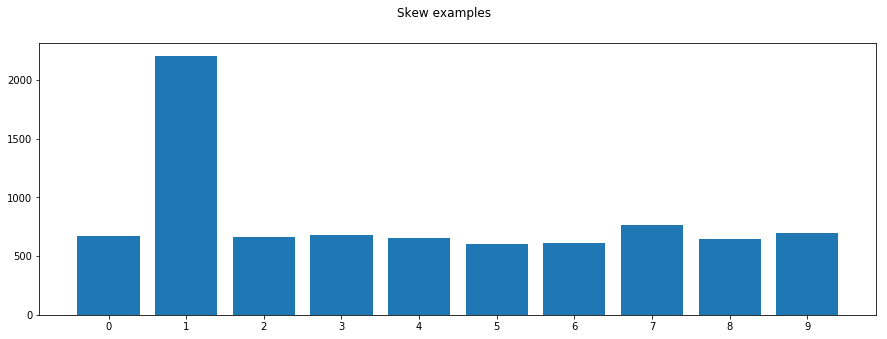

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Skew examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)

In [11]:
import federated

learning_rate = 1e-2
num_epochs = 1
num_rounds = 20

skewed_train_dsets = stacked_data_loaders

manager = federated.FederatedManager(
    skewed_train_dsets,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [12]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) per round.\n" )

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    manager.round()
    print("Finished round", i+1, "with global loss: %.5f" % manager.manager_loss_history[-1], "\n")

  0%|          | 0/20 [00:00<?, ?it/s]

Training 20 round(s) with 10 worker(s) doing 1 epoch(s) per round.

Beginning round 1
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 2.3037
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 2.2598
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 2.2321
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 2.2135
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 2.1831 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 2.2906
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 2.2375
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 2.1772
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 2.1671
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 2.1366 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 2.3009
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 2.2668
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 2.2524
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 2.1894
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 2.2256 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 2.2870
	Worker: 4128 	epoch: 1 	batch: 

  5%|▌         | 1/20 [02:11<41:34, 131.27s/it]

Finished round 1 with global loss: 2.25228 

Beginning round 2
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 2.2559
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 2.1891
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 2.1800
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 2.1402
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 2.0894 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 2.2509
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 2.1753
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 2.1461
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 2.0801
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 1.9798 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 2.2521
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 2.2079
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 2.1629
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 2.1511
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 2.1606 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 2.2477
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 2.1742


 10%|█         | 2/20 [04:21<39:16, 130.93s/it]

Finished round 2 with global loss: 2.19032 

Beginning round 3
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 2.1757
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 2.0809
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 2.0454
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 2.0163
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 2.0598 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 2.1338
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 2.0538
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 1.9383
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 2.0547
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 2.0048 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 2.2140
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 2.1638
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 2.1119
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 2.0336
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 2.0759 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 2.1985
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 2.1147


 15%|█▌        | 3/20 [06:31<37:00, 130.63s/it]

Finished round 3 with global loss: 2.10552 

Beginning round 4
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 2.0868
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 1.9741
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 1.9637
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 1.8912
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 1.8759 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 2.0822
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 1.9088
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 1.8109
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 1.8830
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 1.8509 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 2.1306
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 2.0270
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 1.9713
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 1.9522
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 1.8949 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 2.0853
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 2.0009


 20%|██        | 4/20 [08:41<34:46, 130.42s/it]

Finished round 4 with global loss: 1.98425 

Beginning round 5
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 1.9511
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 1.7967
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 1.7888
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 1.7612
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 1.6627 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 1.9213
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 1.7820
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 1.7049
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 1.6896
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 1.7136 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 2.0053
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 1.8954
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 1.8225
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 1.8208
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 1.8105 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 2.0182
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 1.8863


 25%|██▌       | 5/20 [10:49<32:27, 129.84s/it]

Finished round 5 with global loss: 1.81546 

Beginning round 6
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 1.6863
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 1.6001
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 1.6049
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 1.5169
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 1.4630 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 1.6990
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 1.7135
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 1.5919
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 1.4962
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 1.5684 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 1.8579
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 1.7157
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 1.6576
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 1.6362
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 1.5849 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 1.8222
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 1.7019


 30%|███       | 6/20 [12:55<30:01, 128.67s/it]

Finished round 6 with global loss: 1.60839 

Beginning round 7
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 1.5213
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 1.3747
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 1.3432
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 1.3955
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 1.4018 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 1.5004
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 1.3822
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 1.3533
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 1.3448
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 1.2290 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 1.6626
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 1.4527
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 1.4265
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 1.4471
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 1.4361 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 1.5811
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 1.5385


 35%|███▌      | 7/20 [15:06<28:00, 129.27s/it]

Finished round 7 with global loss: 1.39182 

Beginning round 8
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 1.3348
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 1.1720
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 1.1464
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 1.2424
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 1.0513 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 1.2390
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 1.1087
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 1.1323
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 1.1135
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 1.0674 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 1.4935
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 1.2440
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 1.2781
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 1.1890
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 1.1243 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 1.5463
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 1.3257


 40%|████      | 8/20 [17:21<26:10, 130.89s/it]

Finished round 8 with global loss: 1.19789 

Beginning round 9
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 1.1716
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 1.1943
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 1.0270
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 1.0196
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.8854 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 1.0251
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 1.0024
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 1.0197
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 1.1125
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.8703 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 1.2065
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 1.1280
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 1.2273
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.9730
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 1.0269 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 1.2546
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 1.0630


 45%|████▌     | 9/20 [19:31<23:58, 130.75s/it]

Finished round 9 with global loss: 1.03926 

Beginning round 10
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 0.9866
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 0.9132
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 0.8289
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 0.9415
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.8483 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 0.8820
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 0.9181
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 0.9199
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 0.8671
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.7419 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 1.0406
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 0.9554
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 1.0054
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.8800
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 0.8475 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 0.9400
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 0.9385

 50%|█████     | 10/20 [21:42<21:49, 130.91s/it]

Finished round 10 with global loss: 0.91489 

Beginning round 11
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 0.8709
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 0.7620
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 0.7792
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 0.8727
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.7297 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 0.7890
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 0.7117
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 0.7396
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 0.7581
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.8316 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 0.9221
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 0.9781
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 0.8762
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.7879
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 0.8254 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 0.9650
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 0.790

 55%|█████▌    | 11/20 [23:51<19:33, 130.39s/it]

Finished round 11 with global loss: 0.81936 

Beginning round 12
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 0.7957
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 0.7832
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 0.6571
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 0.6053
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.7506 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 0.8006
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 0.6372
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 0.6832
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 0.7354
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.6520 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 0.7523
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 0.7413
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 0.7910
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.7422
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 0.7966 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 0.8186
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 0.937

 60%|██████    | 12/20 [26:02<17:22, 130.33s/it]

Finished round 12 with global loss: 0.74406 

Beginning round 13
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 0.6523
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 0.6011
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 0.7380
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 0.7418
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.5896 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 0.6521
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 0.6722
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 0.7037
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 0.6451
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.6355 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 0.8363
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 0.7829
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 0.7227
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.6544
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 0.6672 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 0.8126
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 0.663

 65%|██████▌   | 13/20 [28:12<15:12, 130.39s/it]

Finished round 13 with global loss: 0.68538 

Beginning round 14
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 0.6882
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 0.6989
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 0.7205
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 0.5822
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.5608 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 0.6738
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 0.6246
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 0.6140
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 0.4935
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.5622 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 0.7392
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 0.6991
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 0.6648
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.6458
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 0.6842 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 0.7505
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 0.790

 70%|███████   | 14/20 [30:22<13:01, 130.17s/it]

Finished round 14 with global loss: 0.63833 

Beginning round 15
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 0.5771
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 0.5008
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 0.5141
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 0.7280
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.6010 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 0.4527
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 0.5569
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 0.4849
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 0.4845
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.4964 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 0.6179
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 0.7459
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 0.5627
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.7199
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 0.6603 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 0.5940
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 0.643

 75%|███████▌  | 15/20 [32:30<10:47, 129.51s/it]

Finished round 15 with global loss: 0.59931 

Beginning round 16
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 0.4509
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 0.5869
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 0.5914
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 0.4373
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.5573 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 0.4383
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 0.5289
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 0.5671
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 0.5217
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.6216 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 0.6875
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 0.7371
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 0.5351
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.4690
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 0.5223 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 0.6199
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 0.574

 80%|████████  | 16/20 [34:36<08:34, 128.55s/it]

Finished round 16 with global loss: 0.56764 

Beginning round 17
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 0.6120
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 0.5311
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 0.6349
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 0.3677
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.4863 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 0.4084
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 0.5327
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 0.5148
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 0.4622
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.5449 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 0.6196
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 0.4765
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 0.5308
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.6555
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 0.4809 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 0.5618
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 0.566

 85%|████████▌ | 17/20 [36:43<06:24, 128.18s/it]

Finished round 17 with global loss: 0.54121 

Beginning round 18
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 0.6123
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 0.5010
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 0.4376
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 0.4531
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.5151 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 0.4331
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 0.5160
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 0.4955
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 0.4287
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.6457 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 0.5740
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 0.5620
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 0.4851
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.5472
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 0.5020 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 0.5541
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 0.447

 90%|█████████ | 18/20 [38:49<04:15, 127.51s/it]

Finished round 18 with global loss: 0.51869 

Beginning round 19
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 0.4561
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 0.4187
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 0.5154
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 0.4141
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.4903 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 0.5225
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 0.3256
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 0.4108
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 0.4566
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.4847 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 0.4665
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 0.4585
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 0.5208
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.6605
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 0.4586 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 0.5364
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 0.614

 95%|█████████▌| 19/20 [40:56<02:07, 127.28s/it]

Finished round 19 with global loss: 0.49892 

Beginning round 20
	Worker: 3232 	epoch: 1 	batch: 0 	local loss: 0.4760
	Worker: 3232 	epoch: 1 	batch: 16 	local loss: 0.3648
	Worker: 3232 	epoch: 1 	batch: 32 	local loss: 0.4291
	Worker: 3232 	epoch: 1 	batch: 48 	local loss: 0.4508
	Worker: 3232 	epoch: 1 	batch: 64 	local loss: 0.5018 

	Worker: 3120 	epoch: 1 	batch: 0 	local loss: 0.4276
	Worker: 3120 	epoch: 1 	batch: 16 	local loss: 0.4811
	Worker: 3120 	epoch: 1 	batch: 32 	local loss: 0.3240
	Worker: 3120 	epoch: 1 	batch: 48 	local loss: 0.3541
	Worker: 3120 	epoch: 1 	batch: 64 	local loss: 0.6080 

	Worker: 3568 	epoch: 1 	batch: 0 	local loss: 0.4560
	Worker: 3568 	epoch: 1 	batch: 16 	local loss: 0.4787
	Worker: 3568 	epoch: 1 	batch: 32 	local loss: 0.4528
	Worker: 3568 	epoch: 1 	batch: 48 	local loss: 0.5166
	Worker: 3568 	epoch: 1 	batch: 64 	local loss: 0.4613 

	Worker: 4128 	epoch: 1 	batch: 0 	local loss: 0.6005
	Worker: 4128 	epoch: 1 	batch: 16 	local loss: 0.541

100%|██████████| 20/20 [43:02<00:00, 126.91s/it]

Finished round 20 with global loss: 0.48251 



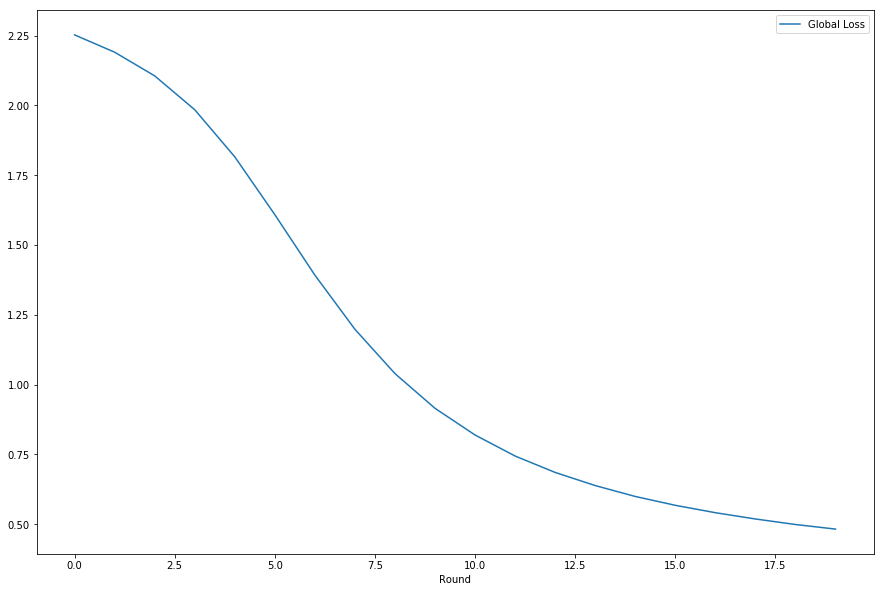

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="Global Loss", )
ax.set_xlabel("Round");
ax.legend();

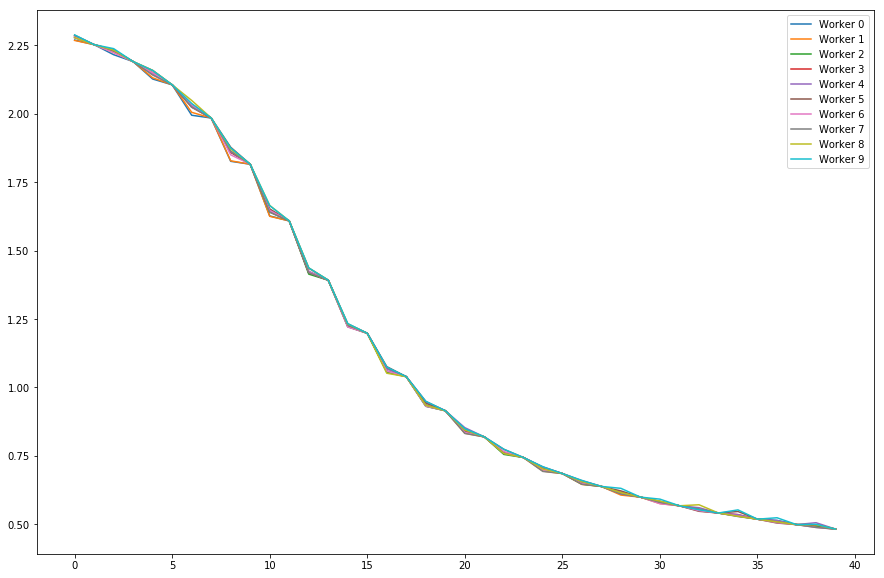

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

for i in range(len(manager.worker_loss_histories)):
    lbl = "Worker " + str(i)
    ax.plot(manager.worker_loss_histories[i], label=lbl)
    ax.legend();

TODO: Write a bit of code that records the hyperparameters and saves the graphs, times and losses in a bundle for each run. Something like:

```
2019-05-06 21:02:50

# standard dataloader parameter
batch_size = 128

# biasing parameters
skew_bias = 0.3
loader_size = 8192
num_workers = 10

Stacked set creation time: 00:01:08

# training parameters
learning_rate = 1e-2
num_epochs = 1
num_rounds = 20

Train time = 00:43:02

Final global loss: 0.48251
```

Outline:
- Set up a model and data
- train the model N epochs without federation note baseline performance (and size of the data that would have to have been transferedd?) 
    - is this model trained on the full dataset? Or do we sample randomly across it to have the same number of examples?
- Federate without skew or mild skew, compare performance with baseline (and size of model compared to data)
- Federate with only a few numbers skewed (like, lacking only 7s or something) 
- Federate with heavy skew
- Federate with complete skew

Ideas:
- plot performance on a given numeral for the main model next to that of a worker skewed against that numeral. Let both run without federation or run a few epochs before federation. Show this as a baseline
- histogram of numerals? More for curiosity, but shows spread of data that we might want to reflect in the baseline training.
- post 1: what's the accuracy loss for federation compared to baseline direct training?
- post 2: weird side stats
    - skew vs. accuracy
        - plot - x-axis = skew, y-axis = accuracy
    - run all to convergence, compare how long to reach comparable accuracy?
        - time or epochs necessary to reach comparable accuracy between federated and standard approach
        - time or epochs necessary to reach comparable accuracy by skew
    - 

Questions:
- Why does the time spent by a worker on any given epoch all happen _before_ the batches start rolling in? What's happening there? Am I just spinning my wheels on something?
    - TODO: try this from a regular python file. The notebook may be buffering up those print statements in the batches
- Why does random selection of the skewed datasets take so long? Is it because they're without replacement?
- Why do all the workers and epochs always happen in order? Wouldn't my laptop parallelize them across cores? Is that too much to ask from an interpreter? Is the interpreter smarter than I am and actually is parallelizing them and the smartest way in to do them in order?
- why use ten workers? Why not fewer?